# Smolyakov2005

$$ H_{ij} = \int \phi_i'(z)\phi_j'(z)dz - \int \phi_i(z)f^2(z)\phi_j(z)dz$$

$$ f_{ij} = \int \phi_i(z)f(z)\phi_j(z)dz $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sinc
plt.rcParams["figure.facecolor"] = "white"

def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    s = 0
    for xq_j, wq_j in zip(xq,wq):
        s += wq_j*func(xq_j)
    return s

# sine DVR
Let $\psi_n(z) = \sqrt{\frac{2}{L}}\sin(\frac{n\pi}{L}(z-x_0)), n=1,\cdots,N$ be the orthorgonal functions on $[x_0,L]$. Then the "coordinate basis" functions is given by

$$ u_j(z) = w_j\sum_{n=1}^N \psi_n(z)\psi_n^*(z_j) $$

where $w_j$ is the j-th weight for the selected quadrature rule and $u_j$ satisfy the Kronecker delta property
$$ u_j(x_k) = \delta_{jk} $$

Now the solution becomes
$$ \xi(z) = \sum_{n=1}^{N} a_n u_n(z) $$

Text(0.5, 1.0, '$ \\int_0^\\pi u_i(x)u_j(x) $')

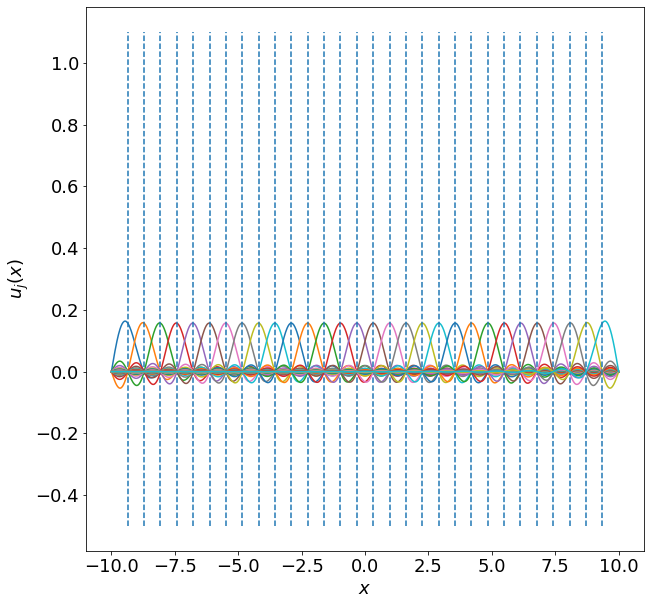

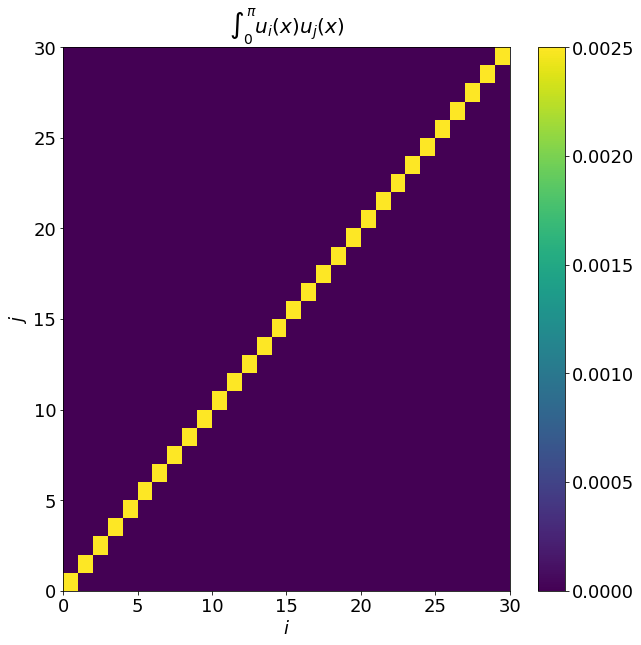

In [245]:
N = 30
L = 20
x0 = -10

xq = np.arange(1,N+1)*L/(N+1) + x0  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
psi = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))
psi_p = lambda x,n: np.sqrt(2/L)*n*np.pi/L*np.cos(n*np.pi/L*(x-x0)) 

def unnomalized_u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

c = quad(lambda x: unnomalized_u(x,0)*unnomalized_u(x,0), xq,wq)
def u(x,j):
    return unnomalized_u(x,j)/np.sqrt(c)

def u_p(x,j):
    s = 0
    for n in range(N+1):
        s += psi_p(x,n)*psi(xq[j],n)/np.sqrt(c)
    return wq[j]*s

x = np.linspace(x0,x0+L,1000)
f = lambda x: 10*np.exp(-x**2)

# plt.figure()
# x = np.linspace(x0,x0+L,1000)
# for j in range(N):
#     plt.plot(x, u(x,j))
#     plt.vlines(xq[j], -0.5,1.1,linestyles='--')
# plt.ylabel("$u_j(x)$")
# plt.xlabel("$x$")

# plt.figure()
# integrals = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
# plt.pcolormesh(integrals)
# plt.colorbar()
# plt.xlabel("$i$")
# plt.ylabel("$j$")
# plt.title("$ \int_0^\pi u_i(x)u_j(x) $")

In [246]:
F = np.zeros((N,N))
H = np.zeros((N,N))
I = np.eye(N)
O = np.zeros_like(I)

for i in range(N):
    for j in range(N):
        F[i,j] = quad(lambda x: u(x,i)*f(x)*u(x,j), xq,wq)
        H[i,j] = quad(lambda x: u_p(x,i)*u_p(x,j) - u(x,i)*f(x)**2*u(x,j), xq,wq)

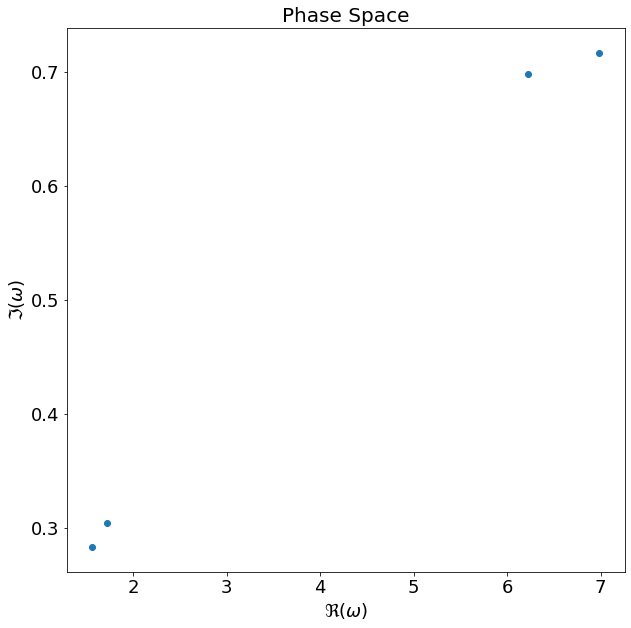

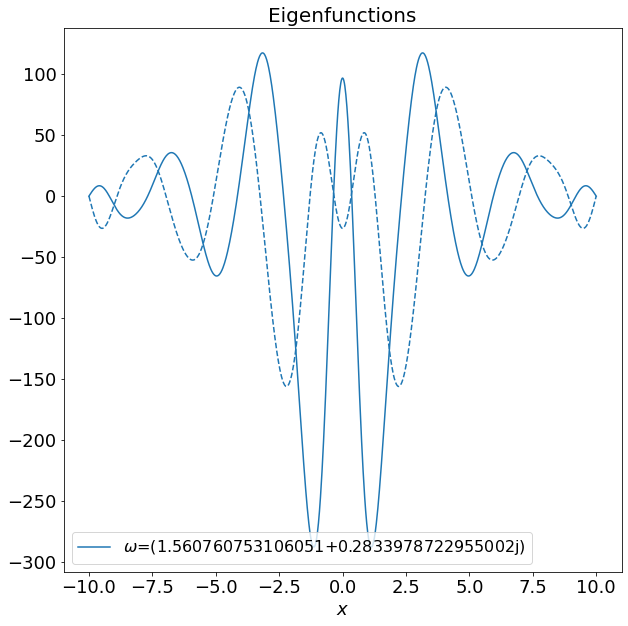

In [252]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[H,2*F]])
omega,C = np.linalg.eig(A)

selection = np.imag(omega)>0
C = C[:N,selection]
omega = omega[selection]

# sort
ind = np.argsort(np.imag(omega))
omega = omega[ind]
C = C[:,ind]



plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
v = 0
for n in range(N):
    v += C[n,1]*u(x,n)/c
line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]}")
plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();

# sinc DVR

In [242]:
dx = 0.25
xq = np.arange(-10,10+dx,dx)  # quadrature points
wq = dx*np.ones_like(xq) # quadrature weights


#psi = lambda x,n: sinc((x-n+(N-1)/2)/dx)/np.sqrt(dx)
# def psi_p_single(x,n):
#     if ((x-n+(N-1)/2)/dx) != 0:
#         return (np.pi*np.cos(np.pi*((x-n+(N-1)/2)/dx))*((x-n+(N-1)/2)/dx)-np.sin(np.pi*((x-n+(N-1)/2)/dx)))/(np.pi*((x-n+(N-1)/2)/dx)**2)/np.sqrt(dx)
#     else:
#         return 0
# psi_p = np.vectorize(psi_p_single)
N = xq.size-2
psi = lambda x,n: sinc((x-xq[n+1])/dx)/np.sqrt(dx)
x = np.linspace(-10,10,3*N)
f = lambda x: 10*np.exp(-x**2)

# plt.figure()
# for n in range(N):
#     plt.plot(x,psi(x,n),label=f"$\psi_{n}$")
# #plt.legend()

# plt.figure()
# integrals = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         integrals[i,j] = quad(lambda x: psi(x,i)*psi(x,j), xq, wq)
# plt.pcolormesh(integrals)
# plt.colorbar()
# plt.xlabel("$i$")
# plt.ylabel("$j$")
# plt.title("$ \int_{-10}^{10} \psi_i(x)\psi_j(x) $")

In [243]:
H = np.zeros((N,N))
F = np.zeros((N,N))
I = np.eye(N)
O = np.zeros_like(I)
for i in range(N):
    for j in range(N):
        H[i,j] = quad(lambda x:-psi(x,i)*f(x)**2*psi(x,j),xq,wq)
        F[i,j] = quad(lambda x:psi(x,i)*f(x)*psi(x,j),xq,wq)
        
        # see professor-notes/damop_talk
        if i == j:
            H[i,j] += np.pi**2/(6*dx**2) * 2
        else:
            H[i,j] += (-1)**(i-j)/(dx*(i-j))**2 *2
A = np.block([[O,I],[H,2*F]])
omega,C = np.linalg.eig(A)
C = C[:N,:]

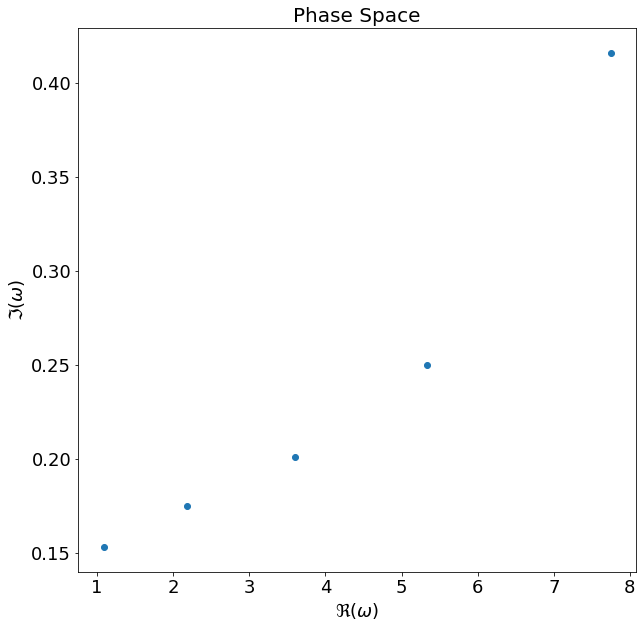

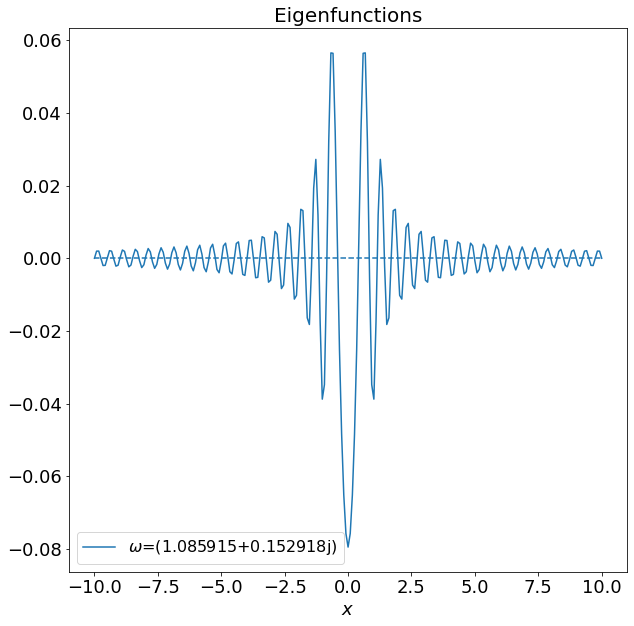

In [244]:
selection = (np.imag(omega) > 0)
omega_ = omega[selection]
C_ = C[:,selection]

plt.figure()
plt.plot(np.real(omega_), np.imag(omega_), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

# sort 
ind = np.argsort(np.imag(omega_))
omega_ = omega_[ind]
C_ = C[:,ind]

plt.figure()
v = 0
for n in range(N):
    v += C_[n,0]*psi(x,n)
line = plt.plot(x, np.real(v), label=f"$\omega$={np.around(omega_[0],6)}")
plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();